In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (8, 8)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import pandas as pd
import os

**Issues:**
1. stats.csv "Category" contains names with spaces, however database directory names don't contain space but underscore.
2. testset.txt image extension is JPEG, whereas the database uses PNG

## Data preparation
### Train test split

In [3]:
SKETCHY_DATABASE_PATH = "../../sketchy-database/"
sketch_stats_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/stats.csv"))
sketch_invalid_ambiguous_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/invalid-ambiguous.txt"), header=None)
sketch_invalid_context_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/invalid-context.txt"), header=None)
sketch_invalid_error_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/invalid-error.txt"), header=None)
sketch_invalid_pose_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/invalid-pose.txt"), header=None)
sketch_testset_df = pd.read_csv(os.path.join(SKETCHY_DATABASE_PATH, "info/testset.txt"), header=None)

In [4]:
def get_sketch_train_test_split( sketch_stats_df, with_ambiguous=False, 
                            with_context=False, with_error=False, 
                            with_pose=False):
    
    sketch_df = sketch_stats_df.copy(deep=True) # don't modify destructively
    
    # Fix "Category" name (See above: issue no. 1)
    sketch_df["Category"] = sketch_df["Category"].apply(lambda x: x.replace(" ", "_"))
    
    # Sketch image file name = <ImageNetID>-<SketchID>."png"
    sketch_df_img_names = sketch_df["ImageNetID"] + "-" + sketch_df["SketchID"].map(str)
    if not with_ambiguous:
        sketch_df = sketch_df.loc[~sketch_df_img_names.isin(sketch_invalid_ambiguous_df[0])]
    if not with_context:
        sketch_df = sketch_df.loc[~sketch_df_img_names.isin(sketch_invalid_context_df[0])]
    if not with_error:
        sketch_df = sketch_df.loc[~sketch_df_img_names.isin(sketch_invalid_error_df[0])]
    if not with_pose:
        sketch_df = sketch_df.loc[~sketch_df_img_names.isin(sketch_invalid_pose_df[0])]
    
    # databse images are in png format, but testset lists them as jpg, 
    # just blending in with the inconsistency for now
    test_samples = sketch_df["ImageNetID"].isin(sketch_testset_df[0].apply(
                                        lambda x: x.split("/")[1].split('.jpg')[0])) 
    sketch_df_train = sketch_df.loc[~test_samples].copy()
    sketch_df_test = sketch_df.loc[test_samples].copy()
    return sketch_df_train, sketch_df_test

In [5]:
sketch_train_df, sketch_test_df = get_sketch_train_test_split(sketch_stats_df) # ignoring samples that are ambiguous; or have context, error, or invalid pose

## Data Exploration

In [23]:
def vis_samples(sketch_df, max_disp=100):
    
    sketch_df = sketch_df[:max_disp].copy()
    sketch_df["img_file_name"] = sketch_df["ImageNetID"] + "-" + sketch_df["SketchID"].map(str)
    
    n_imgs = len(sketch_df)
    n_cols = int(np.ceil(np.sqrt(n_imgs)))
    n_rows = int(np.ceil(1.*n_imgs/n_cols))
    
    for idx, (category, img_file) in enumerate(sketch_df[["Category", "img_file_name"]].values):
        img_dir = os.path.join(SKETCHY_DATABASE_PATH, "rendered_256x256/256x256/sketch/tx_000100000000/", category)
        img = plt.imread(os.path.expanduser(os.path.join(img_dir, img_file + ".png")))
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img), plt.axis("off")
        plt.title(category)

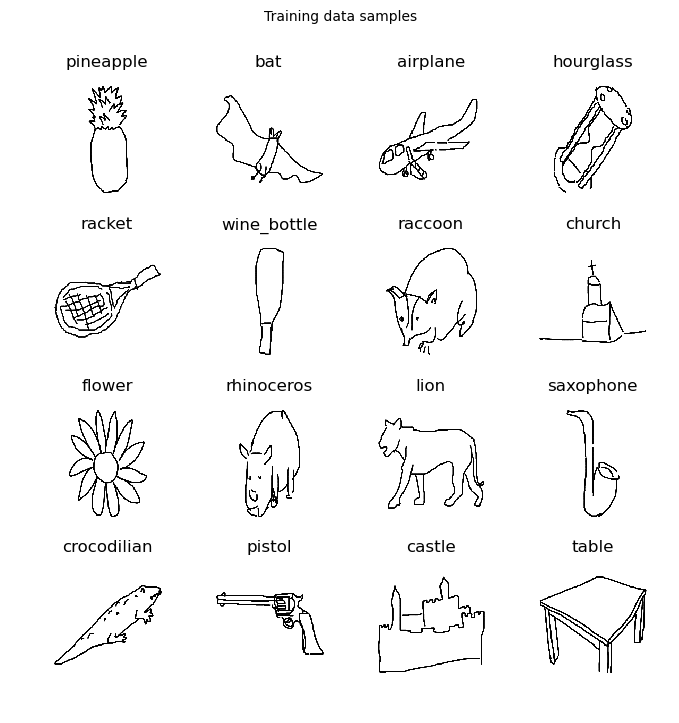

In [24]:
# np.random.seed(0)
disp_samples = 16
vis_samples(sketch_train_df.loc[np.random.choice(sketch_train_df.index, disp_samples, replace=False)])
plt.suptitle("Training data samples")